In [1]:
%matplotlib inline

In [2]:
pwd

'/data2/mito_lineage/Analysis/peaks_expression/CHIP_april08_2021'

In [3]:
config_f = "config.yaml"
outdir=""

In [4]:
import os
if outdir == "":
    outdir="./output"

if not os.path.exists(outdir):
    os.mkdir(outdir)

In [5]:
from src.utils.parse_config import read_config_file
from os.path import join, dirname
import pandas as pd
from glob import glob
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import mplh.cluster_help as ch
%load_ext autoreload
%autoreload 2

In [6]:
config = read_config_file(config_f)
chip_genes = config["chip_genes"]
config


{'global': 'PROJECT',
 'indir': '/data2/isshamie/mito_lineage/data/processed/mtscATAC/CHIP_april08_2021_Croker/MTblacklist',
 'experiment': 'CHIP_april08_2021',
 'genome': 'MTblacklist',
 'chip_genes': ['TP53', 'U2AF1', 'SF3B1', 'SRSF2', 'TET2', 'IDH1', 'IDH2'],
 'samples': ['Control', 'Flt3l', 'Input']}

In [7]:
samples_dict = {ind+1: val for ind, val in enumerate(config["samples"])}

### Load:
1. Raw cells barcode w qc info
2. filtered cells barcode list
3. Peak-by-cell sparse matrix
4. Peak gene annotations 
5. Graph clustering filtered cells cluster label
6. TF-by-cell sparse count matrix
7. TF labels

In [8]:
#curr_in = join(config["indir"], config['CBs'][0], 'outs')

curr_in = join(config["indir"], "aggregate", "outs")
#CBs = pd.read_csv(join(config["indir"], "barcodes_conditionInfo.csv"), header=None)
#CBs = CBs.drop(0,axis=1).rename({1:"Condition"}, axis=1)
#CBs.index=CBs.index+1
CBs = pd.read_csv(join(curr_in, "singlecell.csv"))
CBs.index= CBs.index+1
CBs["Condition ID"] = CBs["barcode"].apply(lambda x: x.split("-")[-1])
CBs["Condition"] = CBs["Condition ID"].astype(int).map(samples_dict)
CBs.head()

,barcode,TSS_fragments,DNase_sensitive_region_fragments,enhancer_region_fragments,promoter_region_fragments,on_target_fragments,blacklist_region_fragments,peak_region_fragments,peak_region_cutsites,passed_filters,duplicate,cell_id,is__cell_barcode,Condition ID,Condition
1,AAACGAAAGAAAGCAG-1,5,0,0,0,5,0,4,7,42,219,None,0,1,Control
2,AAACGAAAGAAAGCAG-2,10,0,0,0,10,0,4,8,84,61,None,0,2,Flt3l
3,AAACGAAAGAAATACC-1,0,0,0,0,0,0,0,0,1,0,None,0,1,Control
4,AAACGAAAGAACAGGA-2,3,0,0,0,3,0,3,6,5,6,None,0,2,Flt3l
5,AAACGAAAGAACCATA-2,0,0,0,0,0,0,0,0,1,0,None,0,2,Flt3l


In [9]:
cell_inds = pd.read_csv(join(curr_in, "filtered_peak_bc_matrix","barcodes.tsv"),header=None)
## Load peak annotations

peak_annotations = pd.read_csv(join(curr_in,'peak_annotation.tsv'),sep='\t')
peak_annotations.index=peak_annotations.index+1
peak_annotations["gene"] = peak_annotations["gene"].str.upper()
peak_annotations["Peak"]= peak_annotations.index
# peak_annotations


### Load clusters and add to CBs
cluster_f = glob(join(curr_in,'analysis',"clustering", "graphclust","clusters.csv"))
clusters_df = pd.read_csv(cluster_f[0])
clusters_df.index=clusters_df.index+1

CBs=pd.concat((CBs,clusters_df), axis=1)

## Load peaks matrix
filename = join(curr_in,'filtered_peak_bc_matrix/matrix.mtx')
peaks_sparse_mtx = pd.read_csv(filename,sep=' ',skiprows=2, header=None).iloc[1:].reset_index(drop=True)
peaks_sparse_mtx.columns = ["Peak", "Cell", "Count"]



## Look at marker genes from Lin et al

In [10]:
# chip_markers ={"cKit":"KIT", 
#                  "Sca1": "LY6E", #"Ly6a",  #?? LY6K LY6E LY6H
#                  "CD11c": "ITGAX",
#                  "CD150": "SLAMF1", 
#                  "CD34": "CD34", 
#                  "CD16/32":"FCGR3A", 
#                  "CD45.1": "PTPRC",
#                  "CD45.2":"PTPRC", 
#                  "CD48": "SLAMF2", # Other SLAMFs
#                  "IL7Ra":"IL7R", 
#                  "CD11b":"ITGAM"}
# chip_genes = list(chip_markers.values())
# chip_genes

## Filter for the chip genes 
Uses peak_annotations

In [11]:
set(peak_annotations['peak_type'])

{'distal',
 'distal;distal',
 'distal;distal;distal',
 'distal;distal;distal;distal',
 'distal;distal;distal;distal;distal',
 'distal;distal;distal;distal;distal;distal',
 'distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal',
 'distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal',
 'distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal',
 'distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal',
 'distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal',
 'distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;distal;di

In [12]:
chip_anno = peak_annotations[peak_annotations["gene"].isin(chip_genes)].set_index("Peak", drop=True).copy()
chip_anno.head()

,peak,gene,distance,peak_type
Peak,,,,
23273,chr2_197378400_197378845,SF3B1,56182,distal
23274,chr2_197433869_197436173,SF3B1,0,promoter
23275,chr2_197442806_197443246,SF3B1,-7716,distal
23276,chr2_197443756_197444291,SF3B1,-8666,distal
23858,chr2_208245818_208246098,IDH1,8224,distal


In [13]:
peaks_sparse_mtx = peaks_sparse_mtx.loc[peaks_sparse_mtx["Peak"].isin(chip_anno.index)]
peaks_sparse_mtx["gene"] = peaks_sparse_mtx["Peak"].map(peak_annotations["gene"])
peaks_sparse_mtx["Cluster"] = peaks_sparse_mtx["Cell"].map(clusters_df["Cluster"])
peaks_dense = peaks_sparse_mtx.pivot(index="Peak", columns="Cell",values="Count").fillna(0)

## The number of cells within a peak and number of peaks within a cell.

Text(0.5, 1.0, 'Distribution of number of peaks seen in a cell across all cells')

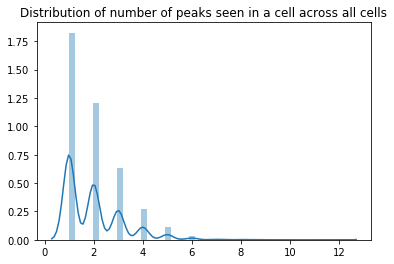

In [14]:
%matplotlib inline
sns.distplot((peaks_dense>0).sum(axis=0))
plt.title("Distribution of number of peaks seen in a cell across all cells")

Text(0.5, 1.0, 'Distribution of the number of cells seen in a peak across all peaks')

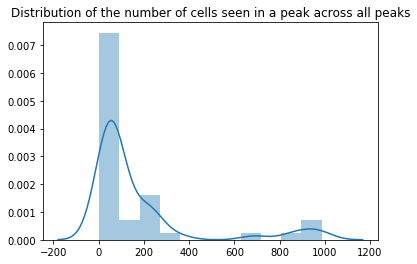

In [15]:
%matplotlib inline
sns.distplot((peaks_dense>0).sum(axis=1))
plt.title("Distribution of the number of cells seen in a peak across all peaks")

In [16]:
#chip_anno = peak_annotations[peak_annotations["gene"].isin(chip_genes)].copy()
#chip_inds = peak_annotations.index
chip_anno["ID"] = chip_anno.apply(lambda x: x["gene"]+"_"+x["peak_type"]+"_"+x["distance"],axis=1)
chip_peaks_dense = peaks_dense.loc[chip_anno.index].copy()
#chip_peaks_dense = chip_peaks_dense.rename(chip_anno.set_index("Peak").apply(lambda x: x["gene"]+"_"+x["peak_type"],axis=1), axis=0)
#chip_peaks_dense

## Cluster based on IM genes 

### a. Dont cluster the chip peaks

In [17]:
# %matplotlib inline
# #rand_df = chip_peaks_dense.sample(n=500,axis=1)
# ch.plot_cluster(chip_peaks_dense.fillna(0), row_meta=chip_anno[["gene", "peak_type"]], 
#                 col_meta=CBs[["Condition", "Cluster"]], to_row_clust=False, row_names=False,
#                 metric='jaccard', to_legend=True, white_name=None )

### b. Clustering the chip peaks as well
and binarizing the results as 0 or >0

clustering
cmap None


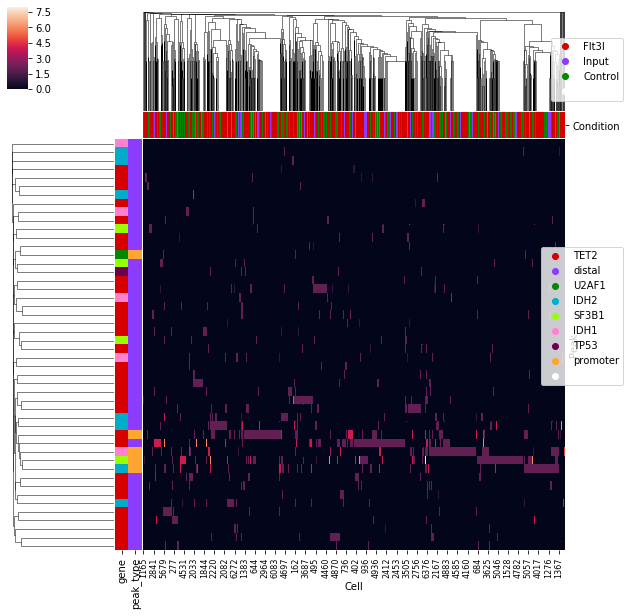

In [18]:
#geneType_chip_anno = chip_anno.rename(chip_anno.apply(lambda x: x["gene"]+"_"+x["peak_type"],axis=1), axis=0)
rand_df = chip_peaks_dense.sample(n=1000,axis=1)
ch.plot_cluster(rand_df.fillna(0), row_meta=chip_anno[["gene", "peak_type"]], 
                col_meta=CBs.drop(["Barcode","Cluster"],axis=1).loc[rand_df.columns][["Condition"]], to_row_clust=True, 
                metric='jaccard', to_legend=True, white_name=None, row_names=False )
plt.savefig(join(outdir, "CHIP_genes_chromatinFragments.png"), bbox_inches='tight')

## Countplots for each gene and peak type

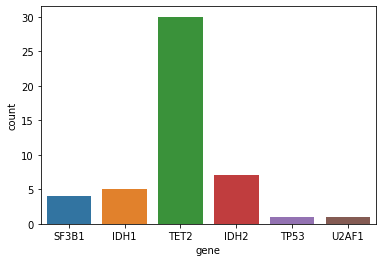

In [19]:
sns.countplot(chip_anno["gene"])

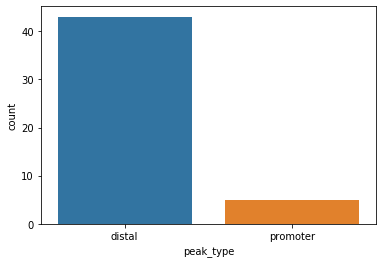

In [20]:
sns.countplot(chip_anno["peak_type"])